In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

### $\textbf{Exercice 2 : Monte Carlo du troisième coefficient du viriel}$

### $Q1. a.$

Le calcul du troisième coefficient du viriel $a_3$ nécessite l'intégration du produit des fonctions de Mayer $f_{12}f_{13}f_{23}$. La méthode de Monte Carlo échantillonne uniformément les positions $\vec{r}_2$ et $\vec{r}_3$ dans le grand volume $V$ du système, et est inefficace en raison de la nature à courte portée du potentiel d'interaction utilisé (le puit carré). Par définition, la fonction de Mayer $f_{ij} = e^{-\beta u(r_{ij})} - 1$ est non nulle uniquement si la distance $r_{ij}$ est inférieure à la portée maximale d'interaction $\tau\sigma$. Donc, l'intégrande $f_{12}f_{13}f_{23}$ ne contribue au résultat que quand les trois particules (1, 2, et 3) sont simultanément en interaction (quand leurs trois distances mutuelles sont $\le \tau\sigma$).

### $b.$

Pour que le produit $f_{12} f_{13} f_{23}$ soit non nul, les trois particules doivent être très proches les unes des autres : chacune des distances $r_{12}, r_{13}$ et $r_{23}$ doit être plus petite que la portée de l’interaction $\tau\sigma$. Cela signifie que, dans l’espace des positions possibles de $\vec r_2$ et $\vec r_3$ (un espace à six dimensions), seules les configurations situées dans une petite zone autour de la particule 1, et où les particules 2 et 3 sont aussi proches l’une de l’autre, comptent réellement. La taille de cette zone utile est de l’ordre de $(\tau\sigma)^6$. Comme $\tau\sigma$ est minuscule par rapport à la taille totale du volume où l’on tire les particules, la probabilité de tomber dans cette zone est proportionnelle à $(\tau\sigma / R_{\max})^6$, c’est-à-dire extrêmement faible. 

### $Q2.a.$

En restreignant l’échantillonnage au domaine $\mathcal{D}$, on impose au moins une condition $r_{12}<R_c$ ou $r_{13}<R_c$. On se concentre uniquement sur des configurations où au moins une paire de particules peut interagir (donc où au moins un $f_{ij}$ peut être non nul). Dans ce domaine, la proportion de configurations où le produit $f_{12}f_{13}f_{23}$ est non nul devient beaucoup plus grande que dans le volume total, ce qui réduit la variance de l’estimateur de $a_3$.

### $b.$

En dehors du domaine $\mathcal{D}$, on a à la fois $r_{12} \ge R_c$ et $r_{13} \ge R_c$, donc $f_{12} = 0$ et $f_{13} = 0$, ce qui implique que le produit $f_{12} f_{13} f_{23}$ est nul. Par conséquent, l’intégrale sur tout l’espace peut être réduite à celle sur le domaine $\mathcal{D}$, et l’on peut écrire
$$\int f_{12} f_{13} f_{23}\, d^3 r_{12}\, d^3 r_{13}
= \int_D f_{12} f_{13} f_{23}\, d^3 r_{12}\, d^3 r_{13}.$$
On définit alors le volume du domaine d’échantillonnage
$V_D = \int_D d^3 r_{12}\, d^3 r_{13}$,
et, pour toute fonction $A(\vec r_2,\vec r_3)$, la moyenne uniforme sur $\mathcal{D}$ par
$$\langle A \rangle_D = \frac{1}{V_D} \int_D A(\vec r_2,\vec r_3)\, d^3 r_{12}\, d^3 r_{13}.$$
En appliquant cette définition à $A = f_{12} f_{13} f_{23}$, on obtient
$$\int_D f_{12} f_{13} f_{23}\, d^3 r_{12}\, d^3 r_{13}
= V_D \,\langle f_{12} f_{13} f_{23} \rangle_D.$$
En remplaçant dans la formule de départ de $a_3$, on trouve :
$$a_3 = -\frac{V_D}{3\lambda^6}\,\langle f_{12} f_{13} f_{23} \rangle_D.$$

### $Q3.a.$

In [ ]:
kB = 1.0  
sigma = 1.0 
tau = 1.5 
epsilon = 2.0  
h = 1.0 
m = 1.0  
block_size = 1000  

def sample_in_sphere(Rc):
    '''
    Rc : rayon Rc
    Retourne : position aléatoire uniformément distribuée dans une sphère de rayon Rc
    '''
    u = random.uniform(0, 1)
    phi = random.uniform(0, 2*np.pi)
    cos_theta = random.uniform(-1, 1)  # Sampler cos(theta) uniformément pour distribution uniforme
    sin_theta = np.sqrt(1 - cos_theta**2)
    r = Rc * (u ** (1/3))
    pos = np.array([r * sin_theta * np.cos(phi), r * sin_theta * np.sin(phi), r * cos_theta])
    return pos

def Mayer_function(rij, T, sigma=sigma, tau=tau, epsilon=epsilon):
    '''
    rij : distance entre deux particules
    T : température
    Retourne : valeur de la fonction de Mayer
    '''
    if rij < sigma:
        return -1
    elif sigma <= rij < sigma * tau:
        return np.exp(epsilon / (kB * T)) - 1
    else:
        return 0

In [ ]:
def estimate_a3(T, Rc, Ne, sigma=sigma, tau=tau, epsilon=epsilon):
    '''
    T : température
    Rc : rayon Rc
    Ne : nombre d'échantillons Monte Carlo
    Retourne : estimation de a3 et erreur statistique
    '''
    pos_part1 = np.zeros(3)

    if Ne % block_size != 0:
        raise ValueError("Ne doit être un multiple de block_size.")

    n_blocks = Ne // block_size
    block_means = np.zeros(n_blocks)

    for b in range(n_blocks):
        block_sum = 0.0
        for i in range(block_size):

            pos_part2 = sample_in_sphere(Rc)
            pos_part3 = sample_in_sphere(Rc)

            r12 = np.linalg.norm(pos_part1 - pos_part2)
            r13 = np.linalg.norm(pos_part1 - pos_part3)
            r23 = np.linalg.norm(pos_part2 - pos_part3)

            f12 = Mayer_function(r12, T)
            f13 = Mayer_function(r13, T)
            f23 = Mayer_function(r23, T)

            block_sum += f12 * f13 * f23

        block_means[b] = block_sum / block_size

    # Moyenne sur D
    mean_over_D = np.mean(block_means)

    # Erreur statistique 
    std_blocks = np.std(block_means, ddof=1)
    err_mean_over_D = std_blocks / np.sqrt(n_blocks)

    lambda_ = h / np.sqrt(2 * np.pi * m * kB * T)
    V_D = ((4/3) * np.pi * Rc**3)**2

    pref = -V_D / (3 * lambda_**6)
    a3 = pref * mean_over_D
    err_a3 = abs(pref) * err_mean_over_D

    return a3, err_a3

Comme $f(r>R_c)=0$, l’intégrande $f_{12}f_{13}f_{23}$ est nul dès que $r_{12}>R_c$ ou $r_{13}>R_c$. Les seules configurations qui contribuent à l’intégrale sont donc celles vérifiant simultanément $r_{12}<R_c$ et $r_{13}<R_c$. Il est ainsi suffisant d’échantillonner $\vec r_2$ et $\vec r_3$ uniformément dans une sphère de rayon $R_c$ centrée sur la particule 1. 


### $Q3.b.$



Dans l’implémentation numérique décrite à la question 3, les particules 2 et 3 sont échantillonnées indépendamment et uniformément dans une sphère de rayon $R_c$ centrée sur la particule 1.
En trois dimensions, le volume d’une sphère de rayon $R_c$ est $V_{\text{sphère}} = \frac{4}{3}\pi R_c^3.$
Comme $\vec r_2$ et $\vec r_3$ sont tirées indépendamment dans deux sphères identiques, le volume total du domaine d’échantillonnage dans l’espace $(\vec r_2,\vec r_3)$ (de dimension 6) est le produit des deux volumes :
 $$V_D = V_{\text{sphère}} \times V_{\text{sphère}}  = \left(\frac{4}{3}\pi R_c^3\right)^2 = \frac{16}{9}\,\pi^2\,R_c^6.$$

### $c.$ 
Voir prochaine cellule de code.

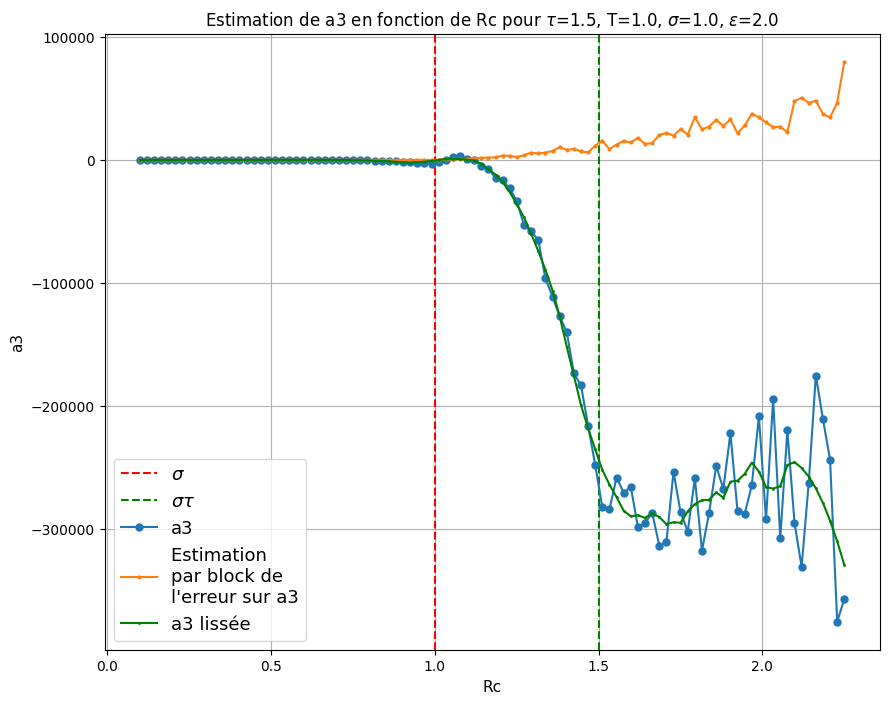

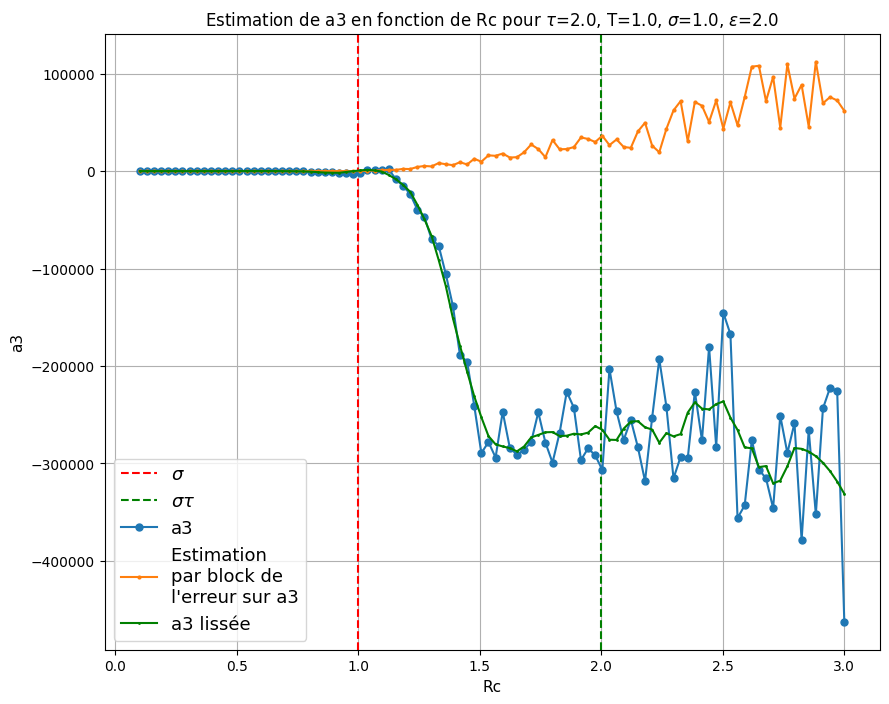

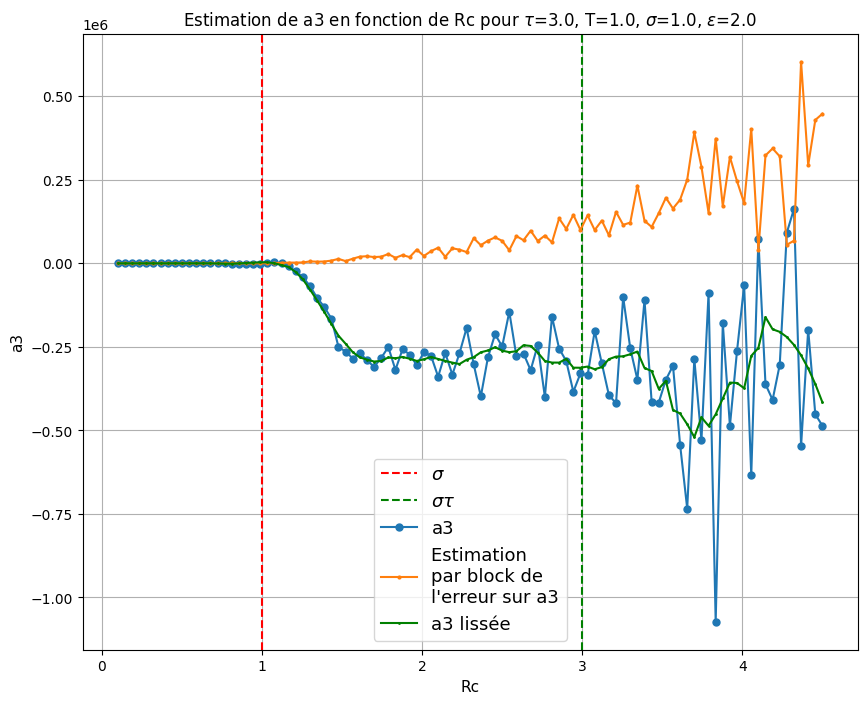

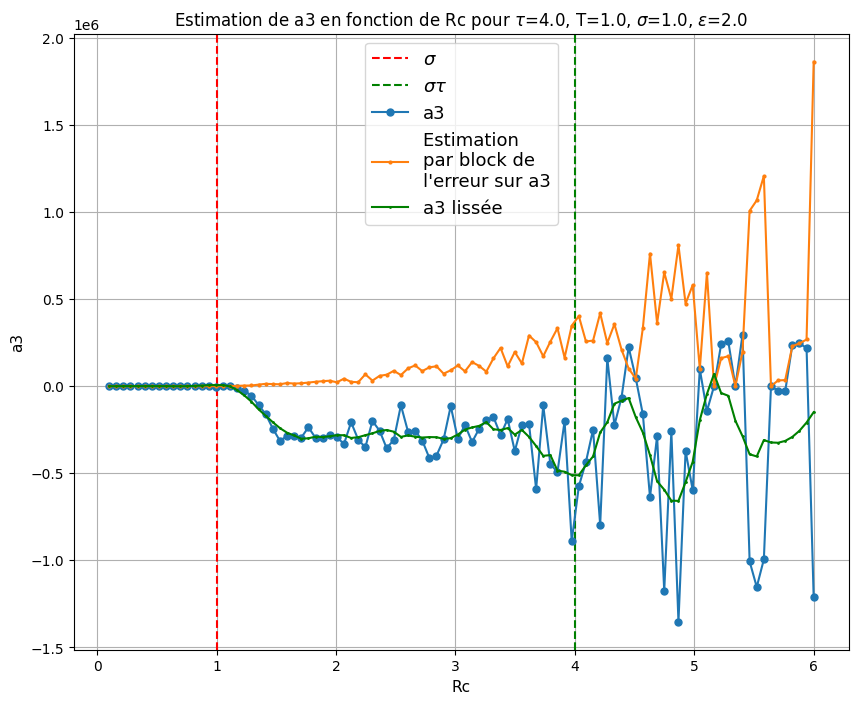

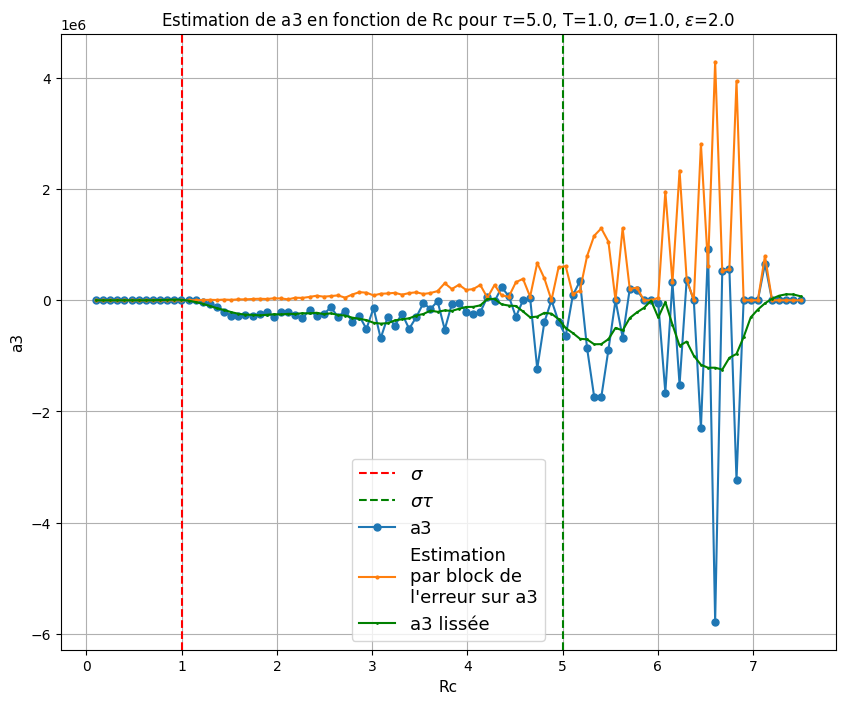

In [ ]:
from scipy.signal import savgol_filter

taus = [1.5, 2.0, 3.0, 4.0, 5.0]
T = 1.0 
number_of_Rc = 100

for tau in taus:
    a3_values = []
    err_a3_values = []
    total = number_of_Rc
    for Rc in np.linspace(0.1, 1.5*sigma*tau, number_of_Rc):
        a3, err_a3 = estimate_a3(T=T, Rc=Rc, Ne=10000, sigma=sigma, tau=tau, epsilon=epsilon)
        a3_values.append(a3)
        err_a3_values.append(err_a3)

    plt.figure(figsize=(10, 8))
    plt.axvline(sigma, color='r', linestyle='dashed', label=r'$\sigma$')
    plt.axvline(sigma*tau, color='g', linestyle='dashed', label=r'$\sigma\tau$')
    plt.plot(np.linspace(0.1, 1.5*sigma*tau, number_of_Rc), a3_values, marker='o', markersize = 5, label = "a3")
    plt.plot(np.linspace(0.1, 1.5*sigma*tau, number_of_Rc), err_a3_values, marker='o', markersize = 2, label = "Estimation \npar block de \nl'erreur sur a3")
    plt.plot(np.linspace(0.1, 1.5*sigma*tau, number_of_Rc), savgol_filter(a3_values, window_length=15, polyorder=2), marker='o', markersize = 1, label = "a3 lissée", color='green') 
    plt.xlabel('Rc', fontsize=11)
    plt.ylabel('a3', fontsize=11)
    plt.title(rf'Estimation de a3 en fonction de Rc pour $\tau$={tau}, T={T}, $\sigma$={sigma}, $\epsilon$={epsilon}')
    plt.legend(fontsize=13)
    plt.grid(True)
    plt.show()

On peut identifier des plateaux à partir de $\approx Rc = 1.5$, mais relativement mal à cause de l'erreur sur a3 (bruit) qui augmente très rapidement avec $Rc$ à cause du facteur $Rc^6$ dans le calcul du volume de D dans l'expression de $a_3$. On essaie alors de lisser les plots pour mieux voir les plateaux. 


### $Q4.a.$

/var/folders/2t/yxlxkxpx0cq1z7q_4zj_k9tc0000gn/T/ipykernel_16212/1662037968.py:19: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(Ts, a3_vals, yerr=a3_errs, fmt='o-', linestyle='None')


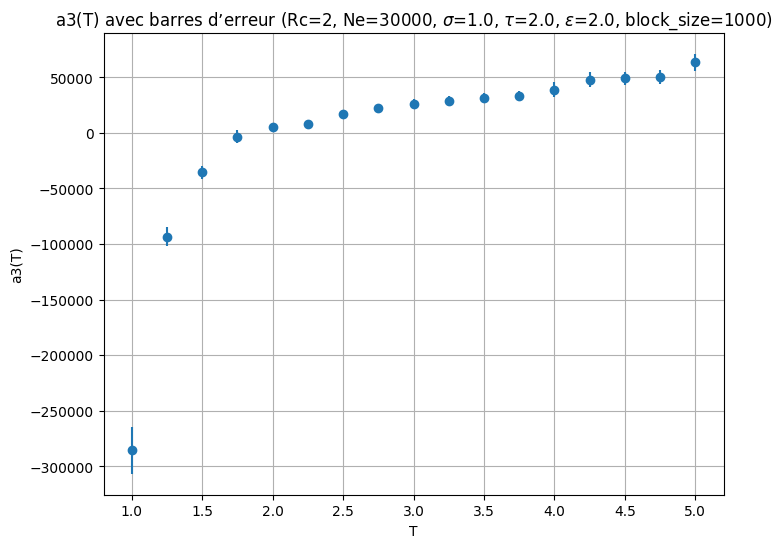

In [5]:
tau = 2.0
sigma = 1.0 
Ne = 30000
Rc = tau * sigma       
Ts = np.linspace(1.0, 5.0, 17)  # 17 points entre 1 et 5

a3_vals = []
a3_errs = []

for T in Ts:
    a3, ea3 = estimate_a3(T=T, Rc=Rc, Ne=Ne, sigma=sigma, tau=tau, epsilon=epsilon)
    a3_vals.append(a3)
    a3_errs.append(ea3)

a3_vals = np.array(a3_vals)
a3_errs = np.array(a3_errs)

plt.figure(figsize=(8, 6))
plt.errorbar(Ts, a3_vals, yerr=a3_errs, fmt='o-', linestyle='None')
plt.xlabel('T')
plt.ylabel('a3(T)')
plt.title(rf'a3(T) avec barres d’erreur (Rc={Rc:.3g}, Ne={Ne}, $\sigma$={sigma}, $\tau$={tau}, $\epsilon$={epsilon}, block_size={block_size})')
plt.grid(True)
plt.show()


### $b.$ 
On observe que $a_3(T)$ est fortement négatif à basse température, à cause  de la domination des configurations attractives dans le potentiel à puits carré. Lorsque la température augmente, la contribution attractive $f_{ij} = e^{\beta \varepsilon} - 1$ décroît, tandis que la répulsion de type cœur dur, indépendante de $T$ devient dominante.  Cette compétition entre énergie (basses températures) et entropie (hautes températures) conduit à une augmentation monotone de $a_3(T)$, qui devient positive à haute température. Les barres d’erreur plus importantes observées à basse température montrent la forte variance associée aux configurations attractives plus rares mais de poids statistique plus élevé.

